In [1]:
import zipfile
import os

# Name of the uploaded zip file
zip_path = "Training.zip"

# Create a directory to extract into
extract_dir = "Training"
os.makedirs(extract_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


📁 SECTION 1 — Imports & Setup

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import Occlusion, visualization as viz
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Device & Seeding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


📁 SECTION 2 — Dataset & Preprocessing

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
VAL_RATIO = 0.2
DATA_DIR = "Training/Training"  # <-- update this if needed

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, indices=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.samples = []
        for label_idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            for file in os.listdir(class_folder):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_folder, file), label_idx))
        self.indices = indices if indices else list(range(len(self.samples)))

    def __len__(self): return len(self.indices)

    def __getitem__(self, idx):
        path, label = self.samples[self.indices[idx]]
        image = Image.open(path).convert('RGB')
        return self.transform(image), label

dataset_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = BrainTumorDataset(DATA_DIR, transform=dataset_transform)
labels = [label for _, label in full_dataset.samples]
train_idx, test_idx = train_test_split(
    range(len(full_dataset.samples)), test_size=VAL_RATIO,
    stratify=labels, random_state=SEED)

train_dataset = BrainTumorDataset(DATA_DIR, dataset_transform, train_idx)
val_dataset   = BrainTumorDataset(DATA_DIR, dataset_transform, test_idx)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(full_dataset.classes)

📁 SECTION 3 — Model: Improved HybridResNetViT

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=1000):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_len, dim))

    def forward(self, x):  # x: [seq_len, batch, dim]
        return x + self.pe[:x.size(0)].unsqueeze(1)

# class ImprovedHybridResNetViT(nn.Module):
#     def __init__(self, num_classes=4, hidden_dim=768, num_heads=12, mlp_dim=3072, num_layers=6):
#         super().__init__()
#         resnet = models.resnet50(weights='IMAGENET1K_V2')
#         self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
#         self.patch_embed = nn.Conv2d(2048, hidden_dim, kernel_size=1)
#         self.flatten = nn.Flatten(2)
#         self.pos_encoder = PositionalEncoding(hidden_dim)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=mlp_dim)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(hidden_dim),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_dim, num_classes)
#         )

#     def forward(self, x):
#         x = self.feature_extractor(x)                   # (B, 2048, H/32, W/32)
#         x = self.patch_embed(x)                         # (B, H, H/32, W/32)
#         x = self.flatten(x).permute(2, 0, 1)            # (S, B, D)
#         x = self.pos_encoder(x)
#         x = self.transformer(x)
#         x = x.mean(dim=0)                               # (B, D)
#         return self.mlp_head(x)

class ImprovedHybridResNetViT(nn.Module):
    def __init__(self, num_classes=4, hidden_dim=768, num_heads=12, mlp_dim=3072, num_layers=6):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])  # (B, 2048, 16, 16)
        self.patch_embed = nn.Conv2d(2048, hidden_dim, kernel_size=1)
        self.flatten = nn.Flatten(2)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.pos_encoder = PositionalEncoding(hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=mlp_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)          # (B, 2048, 16, 16)
        x = self.patch_embed(x)                # (B, 768, 16, 16)
        x = self.flatten(x).permute(2, 0, 1)   # (S=256, B, D=768)

        cls_token = self.cls_token.expand(-1, x.size(1), -1)  # (1, B, D)
        x = torch.cat((cls_token, x), dim=0)   # (257, B, D)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x[0]  # CLS token
        return self.mlp_head(x)


model = ImprovedHybridResNetViT(num_classes=NUM_CLASSES).to(device)

📁 SECTION 4 — Training & Early Stopping

In [5]:
import os
from sklearn.metrics import classification_report

# 📍 Paths for checkpointing
CHECKPOINT_PATH = "hybrid_vit_resnet_best.pth"
EPOCH_LOG_PATH = "last_epoch.txt"
MAX_EPOCHS = 5
RESUME_TRAINING = True

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

# 🔒 Helper to freeze/unfreeze ResNet
def freeze_resnet(model, freeze=True):
    for param in model.feature_extractor.parameters():
        param.requires_grad = not freeze

# 🧠 Training function
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

# 🧪 Validation function with per-class stats
def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("\n" + classification_report(all_labels, all_preds, target_names=full_dataset.classes))
    return total_loss / total, correct / total

# 🔁 Resume training logic
start_epoch = 0
best_acc = 0.0
patience_counter = 0

if RESUME_TRAINING and os.path.exists(CHECKPOINT_PATH) and os.path.exists(EPOCH_LOG_PATH):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    with open(EPOCH_LOG_PATH, "r") as f:
        start_epoch = int(f.read().strip())
    print(f"✅ Resuming from checkpoint at epoch {start_epoch}")
else:
    print("🚀 No checkpoint found — training from scratch.")

# 🏋️ Training Loop
for epoch in range(start_epoch, MAX_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{MAX_EPOCHS}")

    # ❄️ Freeze ResNet only for first epoch
    freeze_resnet(model, freeze=(epoch == 0))

    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    scheduler.step(val_loss)

    print(f"🔍 Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"📉 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        with open(EPOCH_LOG_PATH, "w") as f:
            f.write(str(epoch + 1))
        patience_counter = 0
        print("✅ Model improved and saved.")
    else:
        patience_counter += 1
        print("🕒 No improvement.")
        if patience_counter >= 5:
            print("⏹️ Early stopping triggered.")
            break


✅ Resuming from checkpoint at epoch 5


📁 SECTION 5 — XAI Integration (LIME, ScoreCAM, Occlusion)

Predicted class: 1


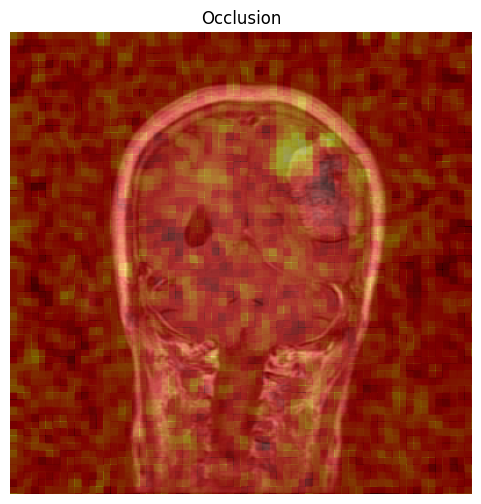

  0%|          | 0/1000 [00:00<?, ?it/s]

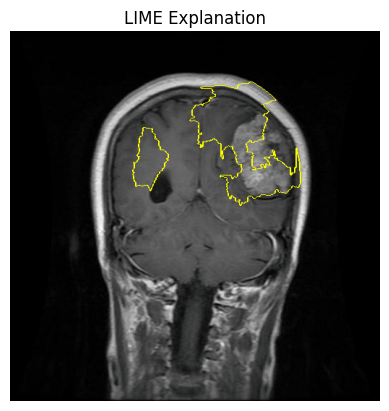

100%|██████████| 128/128 [00:43<00:00,  2.95it/s]


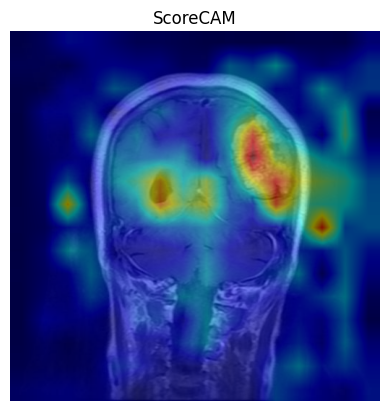

In [6]:
def denormalize(tensor):
    tensor = tensor.cpu().detach().clone()
    return torch.clamp(tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                       torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), 0, 1)

def model_predict(images):
    model.eval()
    batch = [dataset_transform(Image.fromarray(img.astype('uint8'), mode='RGB')) for img in images]
    batch = torch.stack(batch).to(device)
    with torch.no_grad():
        return torch.nn.functional.softmax(model(batch), dim=1).cpu().numpy()

def visualize_attributions(attr, image_tensor, title="Attribution"):
    image = denormalize(image_tensor).permute(1, 2, 0).numpy()
    if attr.dim() == 4: attr = attr.squeeze(0)
    if attr.dim() == 3: attr = np.mean(attr.cpu().numpy(), axis=0)
    elif attr.dim() == 2: attr = attr.cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.imshow(attr, cmap='hot', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

sample_img_tensor, _ = next(iter(val_loader))
sample_img_tensor = sample_img_tensor.to(device)
pred = model(sample_img_tensor)
pred_class = pred.argmax(1)[0].item()
print("Predicted class:", pred_class)


# Occlusion
occlusion = Occlusion(model)
attr = occlusion.attribute(sample_img_tensor[0].unsqueeze(0), strides=(3, 8, 8), sliding_window_shapes=(3, 15, 15), target=pred_class, baselines=0)
visualize_attributions(attr, sample_img_tensor[0], title="Occlusion")

# LIME
img_np = (denormalize(sample_img_tensor[0]).permute(1,2,0).numpy() * 255).astype(np.uint8)
lime = lime_image.LimeImageExplainer()
exp = lime.explain_instance(img_np, model_predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = exp.get_image_and_mask(pred_class, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()

# ScoreCAM
target_layer = model.feature_extractor[-1]
with ScoreCAM(model=model, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=sample_img_tensor[0].unsqueeze(0), targets=[ClassifierOutputTarget(pred_class)])[0]
overlay = show_cam_on_image(denormalize(sample_img_tensor[0]).permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(overlay)
plt.title("ScoreCAM")
plt.axis("off")
plt.show()

